## Реализая U-Net для задачи сегментации датасета Carvana c соревнования Kaggle.

In [1]:
import torch
import torch.nn as nn

## 1. Определние модели.

In [5]:
import torch
import torch.nn as nn
def conv_bn_relu(in_planes, out_planes, kernel=3, stride=1, padding=1):
    net = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=kernel, stride=stride, padding=padding),
                        nn.BatchNorm2d(num_features=out_planes),
                        nn.ReLU(True))
    return net

def unet_block(in_planes, out_planes):
    net = nn.Sequential(conv_bn_relu(in_planes, in_planes, kernel=3, stride=1, padding=1),
                        conv_bn_relu(in_planes, in_planes, kernel=3, stride=1, padding=1), 
                        conv_bn_relu(in_planes, out_planes, kernel=3, stride=2, padding=1))
    return net

def unet_up_block(in_planes, out_planes, padding=0):
    net = nn.Sequential(conv_bn_relu(in_planes, in_planes, kernel=3, stride=1, padding=1),
                        conv_bn_relu(in_planes, in_planes, kernel=3, stride=1, padding=1),
                        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=3, stride=2, padding = padding))
    return net

class SegmenterModel(nn.Module):
    def __init__(self, in_size=3):
        super(SegmenterModel, self).__init__()

        self.features = nn.Sequential()
        
        self.features.add_module("Downsample",
                                 conv_bn_relu(in_planes=in_size, out_planes=8, kernel=3, stride=2, padding=1))

        self.features.add_module("Unet_block_1", unet_block(8,16))
            
        self.features.add_module("Unet_block_2", unet_block(16,32))
        
        self.features.add_module("Unet_up_block_2", unet_up_block(32,16, 1))

        self.features.add_module("Unet_up_block_3", unet_up_block(16,8))

        self.features.add_module("Unet_up_block_4", unet_up_block(8,2))
    
    def forward(self, input, use_cuda):
        res = self.features(input)
        c1 = len(res[0][0]) - 1
        res1 = res[:, :, c1, :].unsqueeze_(2)
        res = torch.cat((res, res1), 2)
        c2 = len(res[0][0][0]) - 1
        res2 = res[:, :, :, c2].unsqueeze_(3)
        res = torch.cat((res, res2), 3)
        return res

## 2.  Препроцессинг датасета.

In [6]:
import torch.utils.data as dt
import torch
import os
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
to_img = ToPILImage()


class CarvanaDataset(dt.Dataset):
    """ 
        Carvana features dataset.  Override torch Dataset class to implements reading from h5 files

    """

    def __init__(self, data_path, mask_path, input_size=224):
        """
        Args:
            data_path (string): Path to the images data files.
            mask_path (string): Path were images masks are placed
        """
        self.files = os.listdir(data_path)
        self.files.sort()
        self.mask_files = os.listdir(mask_path)
        self.mask_files.sort()
        self.data_path = data_path
        self.mask_path = mask_path
        assert (len(self.files) == len(self.mask_files))
        self.input_size = input_size

        self.preprocess = transforms.Compose([
            transforms.Scale((input_size, input_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def pil_load(self, path, is_input=True):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                return img.convert('RGB')

    def pil_save(self, t, img_path):
        a = to_img(t)
        a.save(img_path, 'PNG')

    def __getitem__(self, idx):
        f_name = os.path.join(self.data_path, self.files[idx])
        m_name = os.path.join(self.mask_path, self.mask_files[idx])

        if os.path.exists(f_name) == False:
            raise Exception('Missing file with name ' + f_name + ' in dataset')

        input = self.pil_load(f_name)
        target = self.pil_load(m_name, False)

        input = self.preprocess(input)
        target = self.preprocess(target)
        target = torch.sum(target, dim=0).unsqueeze(0)
        target[ torch.gt(target, 0) ] = 1

        return input, target

## 3. Обучение.

In [7]:
from torch.autograd import Variable
import torch.optim as optim
from tensorboardX import SummaryWriter
import os
from tqdm import *
import numpy as np

useCuda = True
n_epoch = 100
log = './log/'
train = './data/train/'
train_masks = './data/train_masks/'
test = './data/test/'
test_masks = './data/test_masks'

if os.path.exists(log) is False:
    os.mkdir(log)
tb_writer = SummaryWriter(log_dir='log')

if __name__ == '__main__':

    m = SegmenterModel()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(m.parameters(), lr=0.001)

    if useCuda == True:
        m = m.cuda()
        criterion = criterion.cuda()

    ds = CarvanaDataset(train, train_masks)
    ds_test = CarvanaDataset(test, test_masks)
    dl = dt.DataLoader(ds, shuffle=True, num_workers=4, batch_size=5)
    dl_test = dt.DataLoader(ds_test, shuffle=False, num_workers=4, batch_size=5)
    global_iter = 0
    for epoch in range(0, n_epoch):
        print("Current epoch: ", epoch)
        epoch_loss = 0
        m.train(True)
        for iter, (i, t) in enumerate(tqdm(dl)):
            i = Variable(i)
            t = Variable(t.squeeze_(1).long())
            if useCuda:
                i = i.cuda()
                t = t.cuda()
            o = m(i, useCuda)
            if useCuda: o = o.cuda()
            loss = criterion(o, t)
            loss.backward()
            optimizer.step()

            global_iter += 1
            epoch_loss += loss.data[0]

        epoch_loss = epoch_loss / float(len(ds))
        print("Epoch loss", epoch_loss)
        tb_writer.add_scalar('Loss/Train', epoch_loss, epoch)

        print("Make test")
        test_loss = 0
        m.train(False)

        tb_out = np.random.choice(range(0, len(dl_test)), 3)
        for iter, (i, t) in enumerate(tqdm(dl_test)):
            i = Variable(i, volatile=True)
            t.squeeze_(1)
            t = Variable(t.long(), volatile=True)
            if useCuda:
                i = i.cuda()
                t = t.cuda()
            o = m(i, useCuda)
            loss = criterion(o, t)
            test_loss += loss.data[0]

            for k, c in enumerate(tb_out):
                if c == iter:
                    tb_writer.add_image('Image/Test_input_%d' % k, i[0].cpu(), epoch)  # Tensor
                    tb_writer.add_image('Image/Test_target_%d' % k, t[0].cpu(), epoch)  # Tensor
                    tb_writer.add_image('Image/Test_output_%d' % k, o[0].cpu(), epoch)  # Tensor

        test_loss = test_loss / float(len(ds_test))
        print("Test loss", test_loss)
        tb_writer.add_scalar('Loss/Test', test_loss, epoch)

/home/i.kobelev/anaconda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  0%|          | 0/916 [00:00<?, ?it/s]

Current epoch:  0


/home/i.kobelev/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0506, device='cuda:0')
Make test


/home/i.kobelev/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/i.kobelev/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:67: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/i.kobelev/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:73: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0327, device='cuda:0')
Current epoch:  1


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0270, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0229, device='cuda:0')
Current epoch:  2


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0227, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0250, device='cuda:0')
Current epoch:  3


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0233, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0337, device='cuda:0')
Current epoch:  4


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0260, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0334, device='cuda:0')
Current epoch:  5


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0266, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0199, device='cuda:0')
Current epoch:  6


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0283, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0306, device='cuda:0')
Current epoch:  7


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0296, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0383, device='cuda:0')
Current epoch:  8


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0267, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0266, device='cuda:0')
Current epoch:  9


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0248, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0260, device='cuda:0')
Current epoch:  10


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0258, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0152, device='cuda:0')
Current epoch:  11


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0267, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0252, device='cuda:0')
Current epoch:  12


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0274, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0239, device='cuda:0')
Current epoch:  13


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0284, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0298, device='cuda:0')
Current epoch:  14


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0282, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0184, device='cuda:0')
Current epoch:  15


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0308, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0228, device='cuda:0')
Current epoch:  16


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0297, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0184, device='cuda:0')
Current epoch:  17


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0265, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0254, device='cuda:0')
Current epoch:  18


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0340, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0247, device='cuda:0')
Current epoch:  19


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0297, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0233, device='cuda:0')
Current epoch:  20


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0250, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0193, device='cuda:0')
Current epoch:  21


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0258, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0320, device='cuda:0')
Current epoch:  22


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0259, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0194, device='cuda:0')
Current epoch:  23


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0222, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0120, device='cuda:0')
Current epoch:  24


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0180, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0200, device='cuda:0')
Current epoch:  25


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0215, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0254, device='cuda:0')
Current epoch:  26


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0216, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0175, device='cuda:0')
Current epoch:  27


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0161, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0123, device='cuda:0')
Current epoch:  28


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0147, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0151, device='cuda:0')
Current epoch:  29


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0160, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0191, device='cuda:0')
Current epoch:  30


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0217, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0215, device='cuda:0')
Current epoch:  31


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0174, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0143, device='cuda:0')
Current epoch:  32


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0138, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0123, device='cuda:0')
Current epoch:  33


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0144, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0126, device='cuda:0')
Current epoch:  34


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0135, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0126, device='cuda:0')
Current epoch:  35


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0134, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0114, device='cuda:0')
Current epoch:  36


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0142, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0133, device='cuda:0')
Current epoch:  37


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0145, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0120, device='cuda:0')
Current epoch:  38


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0149, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0141, device='cuda:0')
Current epoch:  39


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0147, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0157, device='cuda:0')
Current epoch:  40


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0136, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0111, device='cuda:0')
Current epoch:  41


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0117, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0083, device='cuda:0')
Current epoch:  42


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0105, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0098, device='cuda:0')
Current epoch:  43


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0118, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0094, device='cuda:0')
Current epoch:  44


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0153, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0178, device='cuda:0')
Current epoch:  45


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0174, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0126, device='cuda:0')
Current epoch:  46


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0182, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0201, device='cuda:0')
Current epoch:  47


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0178, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0161, device='cuda:0')
Current epoch:  48


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0221, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0174, device='cuda:0')
Current epoch:  49


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0213, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0353, device='cuda:0')
Current epoch:  50


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0225, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0268, device='cuda:0')
Current epoch:  51


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0251, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0318, device='cuda:0')
Current epoch:  52


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0250, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0238, device='cuda:0')
Current epoch:  53


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0210, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0246, device='cuda:0')
Current epoch:  54


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0232, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0167, device='cuda:0')
Current epoch:  55


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0240, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0248, device='cuda:0')
Current epoch:  56


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0193, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0201, device='cuda:0')
Current epoch:  57


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0203, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0230, device='cuda:0')
Current epoch:  58


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0191, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0141, device='cuda:0')
Current epoch:  59


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0206, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0198, device='cuda:0')
Current epoch:  60


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0148, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0145, device='cuda:0')
Current epoch:  61


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0172, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0118, device='cuda:0')
Current epoch:  62


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0152, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0168, device='cuda:0')
Current epoch:  63


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0164, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0117, device='cuda:0')
Current epoch:  64


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0134, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0136, device='cuda:0')
Current epoch:  65


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0133, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0149, device='cuda:0')
Current epoch:  66


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0123, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0132, device='cuda:0')
Current epoch:  67


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0155, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0194, device='cuda:0')
Current epoch:  68


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0201, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0201, device='cuda:0')
Current epoch:  69


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0158, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0154, device='cuda:0')
Current epoch:  70


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0158, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0157, device='cuda:0')
Current epoch:  71


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0161, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0154, device='cuda:0')
Current epoch:  72


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0156, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0125, device='cuda:0')
Current epoch:  73


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0123, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0091, device='cuda:0')
Current epoch:  74


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0119, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0137, device='cuda:0')
Current epoch:  75


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0125, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0134, device='cuda:0')
Current epoch:  76


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0144, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0140, device='cuda:0')
Current epoch:  77


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0176, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0178, device='cuda:0')
Current epoch:  78


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0154, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0117, device='cuda:0')
Current epoch:  79


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0130, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0101, device='cuda:0')
Current epoch:  80


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0112, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0075, device='cuda:0')
Current epoch:  81


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0082, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0080, device='cuda:0')
Current epoch:  82


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0108, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0129, device='cuda:0')
Current epoch:  83


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0122, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0128, device='cuda:0')
Current epoch:  84


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0135, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0129, device='cuda:0')
Current epoch:  85


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0149, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0162, device='cuda:0')
Current epoch:  86


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0150, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0129, device='cuda:0')
Current epoch:  87


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0143, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0134, device='cuda:0')
Current epoch:  88


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0120, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0096, device='cuda:0')
Current epoch:  89


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0102, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0085, device='cuda:0')
Current epoch:  90


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0108, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0078, device='cuda:0')
Current epoch:  91


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0117, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0099, device='cuda:0')
Current epoch:  92


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0139, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0124, device='cuda:0')
Current epoch:  93


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0132, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0146, device='cuda:0')
Current epoch:  94


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0125, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0125, device='cuda:0')
Current epoch:  95


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0106, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0108, device='cuda:0')
Current epoch:  96


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0099, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0093, device='cuda:0')
Current epoch:  97


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0104, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0109, device='cuda:0')
Current epoch:  98


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0098, device='cuda:0')
Make test


  0%|          | 0/916 [00:00<?, ?it/s]

Test loss tensor(0.0088, device='cuda:0')
Current epoch:  99


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch loss tensor(0.0096, device='cuda:0')
Make test


100%|██████████| 102/102 [00:11<00:00,  8.94it/s]

Test loss tensor(0.0088, device='cuda:0')


In [42]:
import matplotlib.pyplot as plt



iterator = dl_test.__iter__()
input, objective = next(iterator)
input = input[0].unsqueeze(0)

if useCuda: input = input.cuda()
values, pred = m(input, useCuda).max(1)
if useCuda: 
    input = input.cpu()
    pred = pred.cpu()

pred, input = pred[0].numpy(), input.squeeze(0)[0].numpy()
out1 = np.multiply(pred, input)

## 4. Результат работы модели.

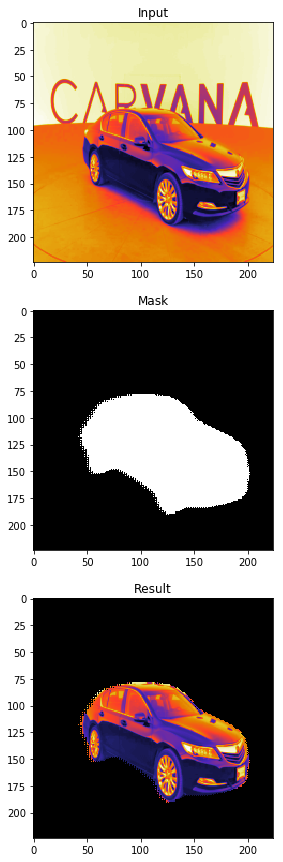

In [46]:
plt.figure(figsize=(15, 15))

plot1= plt.subplot(3, 1, 1)
plot1.set_title("Input")
plot1.imshow(input, cmap='CMRmap')

plot2= plt.subplot(3, 1, 2)
plot2.imshow(pred, cmap='CMRmap')
plot2.set_title("Mask")

plot2= plt.subplot(3, 1, 3)
plot2.imshow(out1, cmap='CMRmap')
plot2.set_title("Result")


plt.show()